In [ ]:
# instalação de pacotes
%%capture
!pip install requests
!pip install python-dateutil
!pip install gnewsclient
!pip install langdetect
!pip install flair

In [ ]:
# importação de bibliotecas e pacotes
%%capture
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
import requests
from langdetect import detect
import string
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
from transformers import BertTokenizer, BertForSequenceClassification
import torch
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Definir a lista de empresas e o período de análise
empresas = ['MGLU3', 'PETR4', 'VALE3']
start_date = '2022-01-01'
end_date = '2022-12-31'

# Df vazio para receber acumular as cotações
cotacoes_df = pd.DataFrame()

# Loop para coletar as cotações
for empresa in empresas:
    print(empresa)
    cotacoes_empresa = yf.download(f'{empresa}.SA', start=start_date, end=end_date)
    cotacoes_empresa['Empresa'] = empresa
    cotacoes_df = pd.concat([cotacoes_df, cotacoes_empresa])

# Trasnformando o índice de data em uma coluna
cotacoes_df.reset_index(inplace=True)
cotacoes_df.rename(columns={'index': 'Date'}, inplace=True)

# Converter a coluna "Date" para o formato de data
cotacoes_df['Date'] = pd.to_datetime(cotacoes_df['Date'])

# Visualização do df
cotacoes_df

MGLU3
[*********************100%***********************]  1 of 1 completed
PETR4
[*********************100%***********************]  1 of 1 completed
VALE3
[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Empresa
0,2022-01-03,7.410000,7.410000,6.670000,6.720000,6.720000,145442000,MGLU3
1,2022-01-04,6.780000,6.940000,6.450000,6.610000,6.610000,94735500,MGLU3
2,2022-01-05,6.520000,6.730000,6.370000,6.420000,6.420000,92667900,MGLU3
3,2022-01-06,6.460000,6.530000,6.130000,6.250000,6.250000,96480700,MGLU3
4,2022-01-07,6.270000,6.630000,6.110000,6.220000,6.220000,132688900,MGLU3
...,...,...,...,...,...,...,...,...
745,2022-12-23,85.279999,86.519997,85.080002,86.320000,84.465065,18656500,VALE3
746,2022-12-26,86.419998,87.540001,86.330002,87.110001,85.238083,18407500,VALE3
747,2022-12-27,88.000000,89.650002,87.470001,89.190002,87.273392,26720300,VALE3
748,2022-12-28,89.190002,90.209999,88.699997,88.989998,87.077682,23314500,VALE3


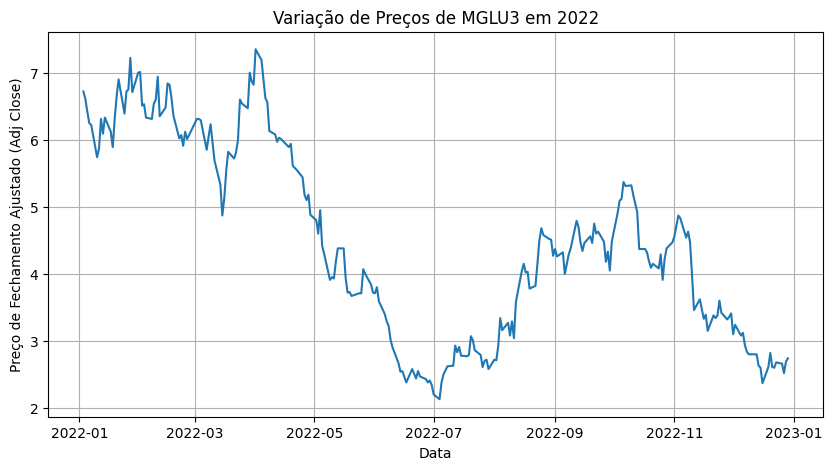

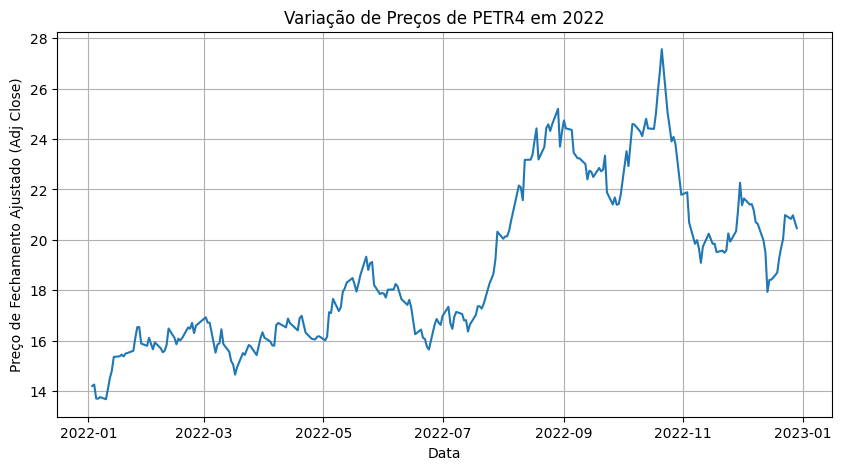

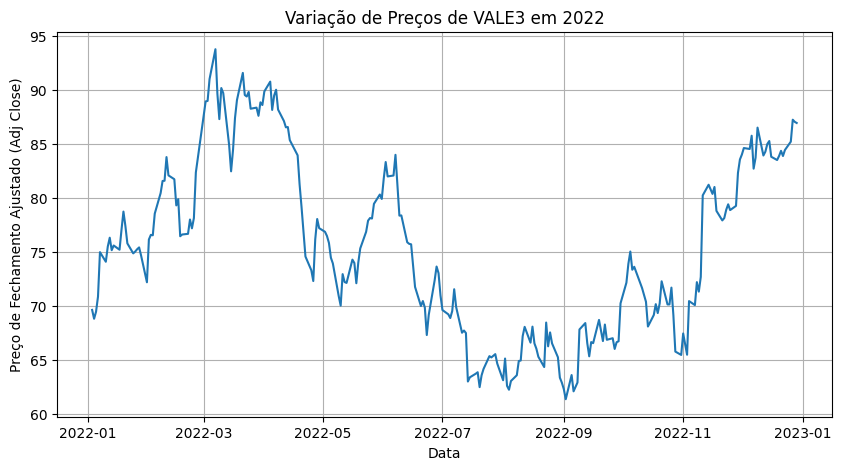

In [ ]:
# Plotar os gráficos individuais para cada empresa
for empresa in empresas:
    df_empresa = cotacoes_df[cotacoes_df['Empresa'] == empresa]
    plt.figure(figsize=(10, 5))
    plt.plot(df_empresa['Date'], df_empresa['Adj Close'])
    plt.title(f"Variação de Preços de {empresa} em 2022")
    plt.xlabel("Data")
    plt.ylabel("Preço de Fechamento Ajustado (Adj Close)")
    plt.grid(True)
    plt.show()

In [ ]:
# Função para pré-processar o texto das notícias
def preprocess_text(text):
    # Remover pontuação
    text = ''.join(char for char in text if char not in string.punctuation)

    # Tokenização
    words = word_tokenize(text.lower())

    # Remover stop words
    stop_words = set(stopwords.words('portuguese'))
    words = [word for word in words if word not in stop_words]

    # Part-of-speech tagging (POS tagging)
    tagged_words = pos_tag(words)

    # Reconstituir o texto pré-processado
    processed_text = ' '.join(words)

    return processed_text

In [ ]:
# Lista para armazenar as notícias em português
noticias_portugues_df = pd.DataFrame()

# Capturar notícias em português para cada empresa
for empresa in empresas:
    # Configurar a consulta de pesquisa para o Google News
    query = f"{empresa} after:{start_date} before:{end_date}"
    url = f"https://news.google.com/rss/search?q={query}&hl=pt-BR&gl=BR&ceid=BR:pt"

    # Obter o feed RSS de notícias do Google News
    response = requests.get(url)
    data = response.text

    # Extrair títulos, descrições e datas das notícias do feed RSS
    start_marker = '<item>'
    end_marker = '</item>'
    titles = [data.split(start_marker)[i+1].split(end_marker)[0].split('<title>')[1].split('</title>')[0] for i in range(data.count(start_marker))]
    descriptions = [data.split(start_marker)[i+1].split(end_marker)[0].split('<description>')[1].split('</description>')[0] for i in range(data.count(start_marker))]
    dates = pd.to_datetime([data.split(start_marker)[i+1].split(end_marker)[0].split('<pubDate>')[1].split('</pubDate>')[0] for i in range(data.count(start_marker))])

    # Verificar o idioma de cada descrição
    lang_descriptions = [description for description in descriptions if detect(description) == 'pt']

    # Criar DataFrame com as notícias em português
    df = pd.DataFrame({'Date': dates[:len(lang_descriptions)], 'Title': titles[:len(lang_descriptions)], 'Description': lang_descriptions})

    # Filtrar notícias pelo período de análise
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Adicionar empresa como coluna
    df['Empresa'] = empresa

    # Adicionar ao DataFrame geral
    noticias_portugues_df = pd.concat([noticias_portugues_df, df])

# Pré-processar o texto das notícias
print("Antes do pré-processamento:")
print(noticias_portugues_df['Description'].iloc[0])  # Imprimir o primeiro conteúdo antes do pré-processamento
noticias_portugues_df['Processed_Text'] = noticias_portugues_df['Description'].apply(preprocess_text)
print("\nApós o pré-processamento:")
print(noticias_portugues_df['Processed_Text'].iloc[0])  # Imprimir o primeiro texto pré-processado

# Realizar a análise de sentimento usando o modelo 'neuralmind/bert-base-portuguese-cased'
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Carregar o modelo BERT pré-treinado para análise de sentimento em português
model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Função para realizar análise de sentimento
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sentiment_score = probabilities[:, 1].item() - probabilities[:, 0].item()
    return sentiment_score

# Realizar a análise de sentimento para cada texto
noticias_portugues_df['Sentiment'] = noticias_portugues_df['Processed_Text'].apply(analyze_sentiment)

# Visualização
print(noticias_portugues_df)

Antes do pré-processamento:
&lt;a href="https://news.google.com/rss/articles/CBMiU2h0dHBzOi8vd3d3LnN1bm8uY29tLmJyL25vdGljaWFzL21hZ2F6aW5lLWx1aXphLW1nbHUzLXBlcnNwZWN0aXZhcy0yMDIzLXByZWNvLWFjYW8v0gFXaHR0cHM6Ly93d3cuc3Vuby5jb20uYnIvbm90aWNpYXMvbWFnYXppbmUtbHVpemEtbWdsdTMtcGVyc3BlY3RpdmFzLTIwMjMtcHJlY28tYWNhby9hbXAv?oc=5" target="_blank"&gt;Magazine Luiza (MGLU3): 2023 será o ano da virada do preço da ação? Veja as perspectivas&lt;/a&gt;&amp;nbsp;&amp;nbsp;&lt;font color="#6f6f6f"&gt;Suno Notícias&lt;/font&gt;

Após o pré-processamento:
lta hrefhttpsnewsgooglecomrssarticlescbmiu2h0dhbzoi8vd3d3lnn1bm8uy29tlmjyl25vdgljawfzl21hz2f6aw5llwx1axphlw1nbhuzlxblcnnwzwn0axzhcy0ymdizlxbyzwnvlwfjyw8v0gfxahr0chm6ly93d3cuc3vuby5jb20uynivbm90awnpyxmvbwfnyxppbmutbhvpemetbwdsdtmtcgvyc3bly3rpdmfzltiwmjmtchjly28tywnhby9hbxavoc5 targetblankgtmagazine luiza mglu3 2023 ano virada preço ação veja perspectivasltagtampnbspampnbspltfont color6f6f6fgtsuno notíciasltfontgt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


                        Date  \
0  2022-11-29 08:00:00+00:00   
1  2022-12-02 08:00:00+00:00   
2  2022-12-02 08:00:00+00:00   
3  2022-12-16 08:00:00+00:00   
4  2022-12-12 08:00:00+00:00   
..                       ...   
26 2022-08-30 07:00:00+00:00   
27 2022-11-29 08:00:00+00:00   
28 2022-12-02 08:00:00+00:00   
29 2022-12-20 08:00:00+00:00   
30 2022-12-22 08:00:00+00:00   

                                                Title  \
0   Magazine Luiza (MGLU3): 2023 será o ano da vir...   
1   Magazine Luiza (MGLU3): ações avançam 4,19%, c...   
2   Goldman Sachs rebaixa Americanas (AMER3) para ...   
3   Magazine Luiza (MGLU3): Itaú BBA e BB Investim...   
4   Magazine Luiza (MGLU3): ações têm queda de 1,7...   
..                                                ...   
26  Vale (VALE3) ou Gerdau (GGBR4): quem reserva m...   
27  Vale (VALE3): ações sobem mais de 4% nesta tar...   
28  BHP entra com pedido de contribuição contra Va...   
29  Vale (VALE3): ações da mineradora avançam

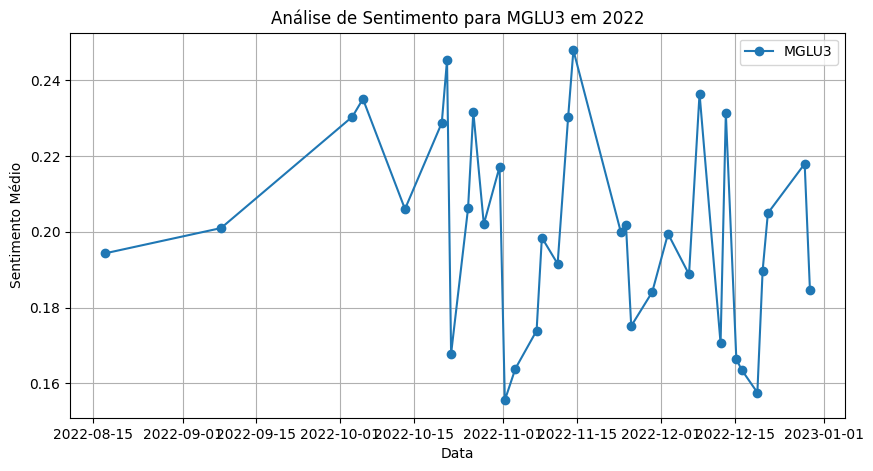

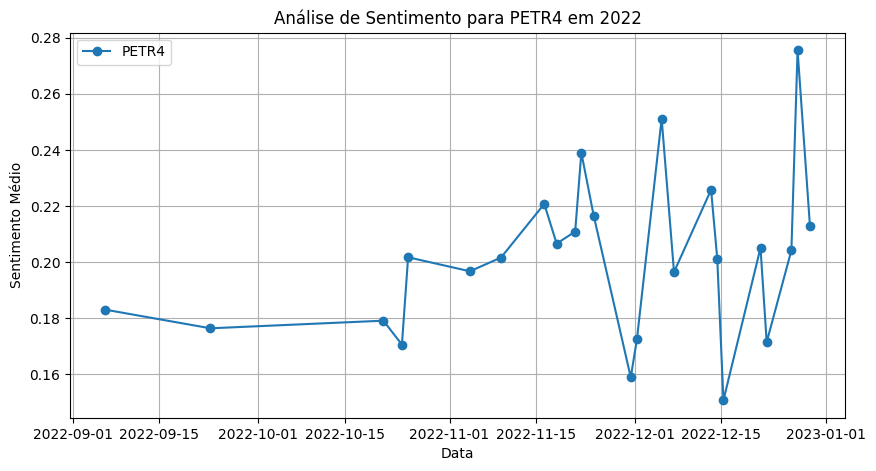

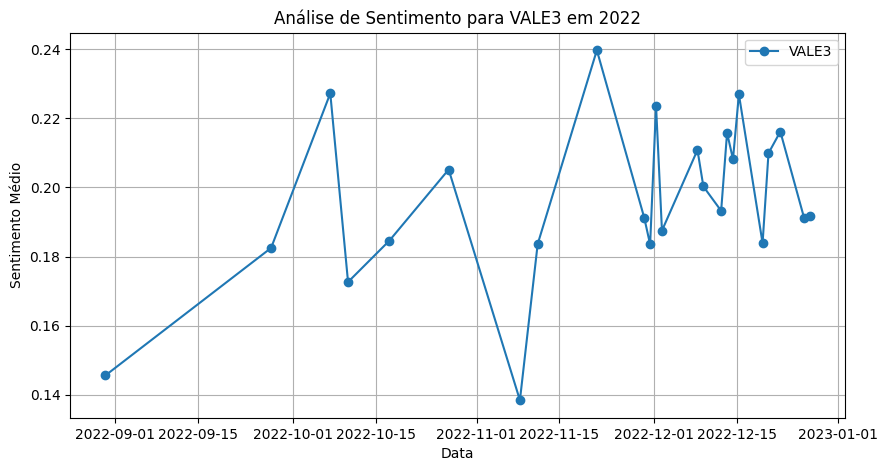

In [ ]:
# Calcular a média do sentimento para cada dia para cada empresa
sentiment_avg_df = noticias_portugues_df.groupby(['Empresa', 'Date'])['Sentiment'].mean().reset_index()

# Criar gráfico temporal para cada empresa
for empresa in empresas:
    df_empresa = sentiment_avg_df[sentiment_avg_df['Empresa'] == empresa]

    plt.figure(figsize=(10, 5))
    plt.plot(df_empresa['Date'], df_empresa['Sentiment'], marker='o', linestyle='-', label=empresa)

    plt.title(f"Análise de Sentimento para {empresa} em 2022")
    plt.xlabel("Data")
    plt.ylabel("Sentimento Médio")
    plt.grid(True)
    plt.legend()
    plt.show()

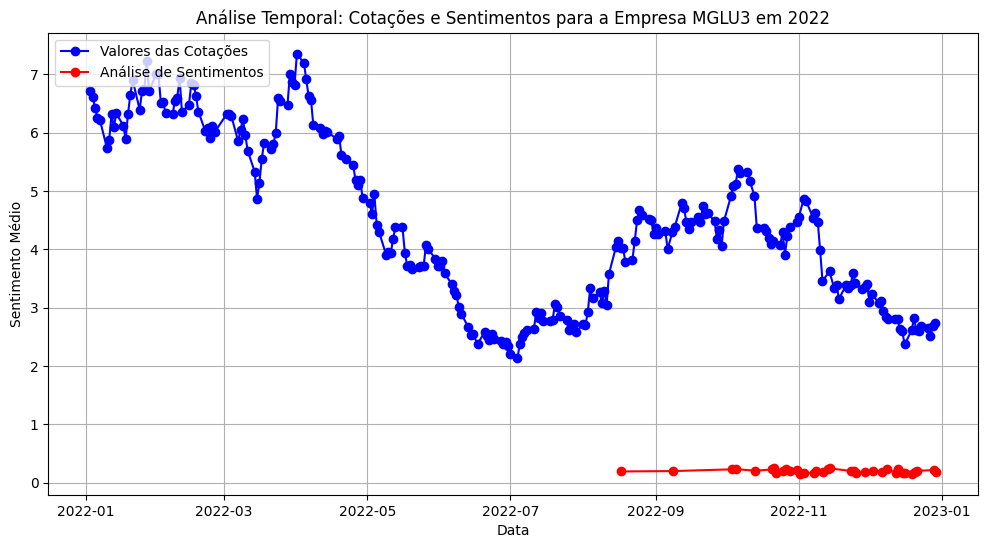

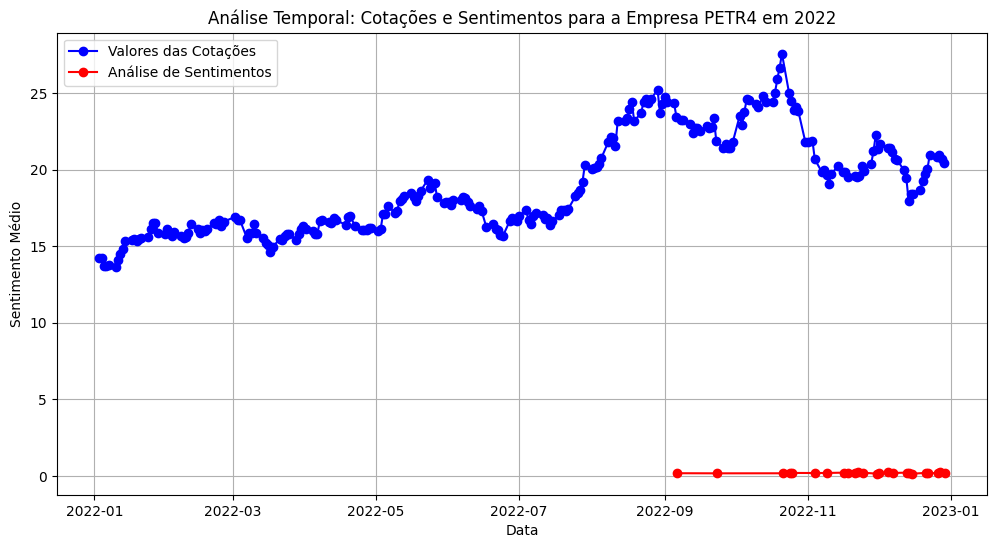

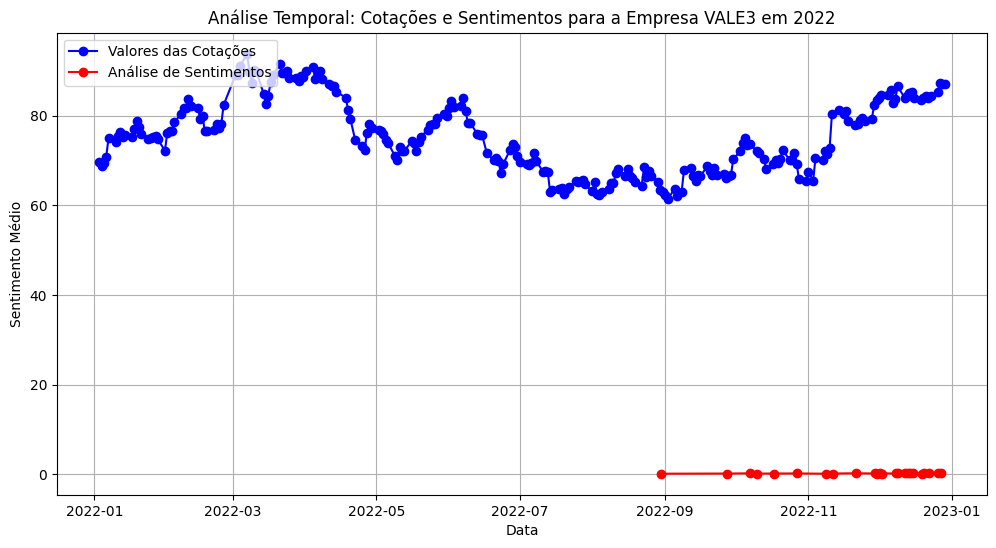

In [ ]:
# Lista de empresas
empresas = ['MGLU3', 'PETR4', 'VALE3']

# Plotar gráfico temporal com duas linhas (Cotação e Sentimento) para cada empresa
for empresa in empresas:
    cotacoes_empresa = cotacoes_df[cotacoes_df['Empresa'] == empresa]
    sentiment_empresa = sentiment_avg_df[sentiment_avg_df['Empresa'] == empresa]

    plt.figure(figsize=(12, 6))

    # Gráfico para os valores das cotações
    plt.plot(cotacoes_empresa['Date'], cotacoes_empresa['Adj Close'], label='Valores das Cotações', color='blue', marker='o', linestyle='-')
    plt.ylabel("Valores das Cotações", color='blue')
    plt.tick_params(axis='y', labelcolor='blue')

    # Gráfico para os valores dos sentimentos
    plt.plot(sentiment_empresa['Date'], sentiment_empresa['Sentiment'], label='Análise de Sentimentos', color='red', marker='o', linestyle='-')
    plt.ylabel("Sentimento Médio", color='black')
    plt.tick_params(axis='y', labelcolor='black')

    plt.title(f"Análise Temporal: Cotações e Sentimentos para a Empresa {empresa} em 2022")
    plt.xlabel("Data")
    plt.grid(True)

    # Adicionar uma legenda única para os dois eixos y
    lines, labels = plt.gca().get_legend_handles_labels()
    plt.gca().legend(lines, labels, loc='upper left')

    plt.show()


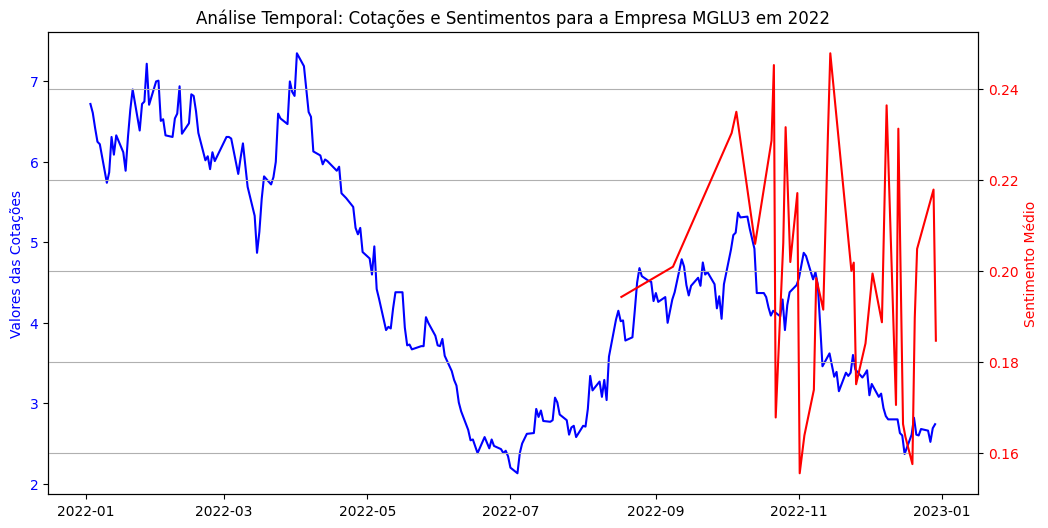

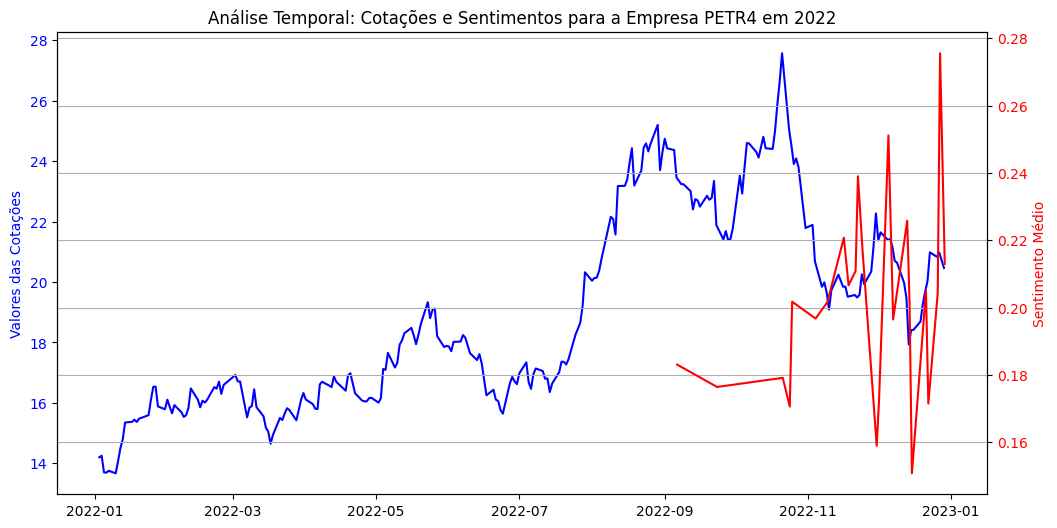

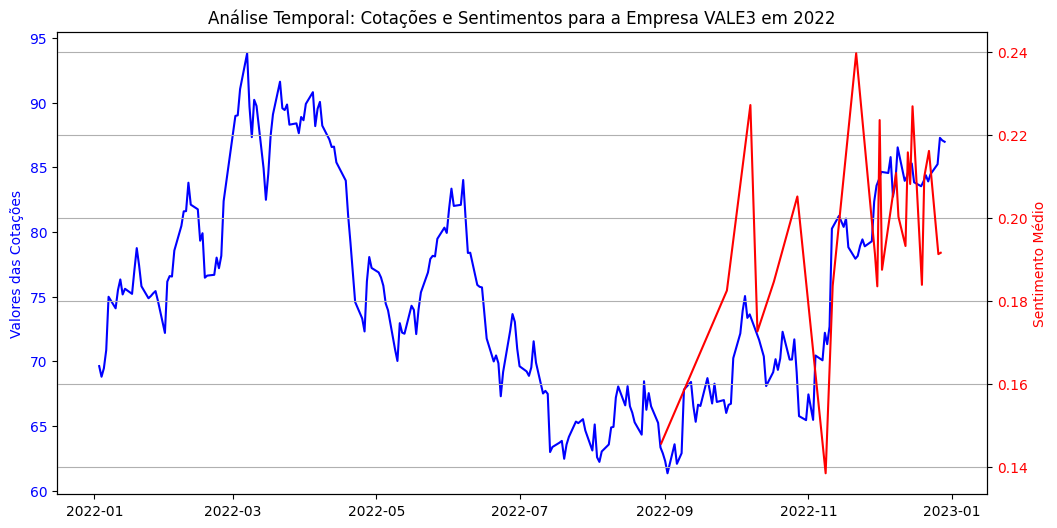

In [ ]:
# Lista de empresas
empresas = ['MGLU3', 'PETR4', 'VALE3']

# Plotar gráfico temporal com duas linhas (Cotação e Sentimento) para cada empresa
for empresa in empresas:
    cotacoes_empresa = cotacoes_df[cotacoes_df['Empresa'] == empresa]
    sentiment_empresa = sentiment_avg_df[sentiment_avg_df['Empresa'] == empresa]

    plt.figure(figsize=(12, 6))

    # Gráfico para os valores das cotações
    plt.plot(cotacoes_empresa['Date'], cotacoes_empresa['Adj Close'], label='Valores das Cotações', color='blue', linestyle='-')
    plt.ylabel("Valores das Cotações", color='blue')
    plt.tick_params(axis='y', labelcolor='blue')

    # Gráfico para os valores dos sentimentos (usando eixo secundário)
    ax2 = plt.twinx()
    ax2.plot(sentiment_empresa['Date'], sentiment_empresa['Sentiment'], label='Análise de Sentimentos', color='red', linestyle='-')
    ax2.set_ylabel("Sentimento Médio", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f"Análise Temporal: Cotações e Sentimentos para a Empresa {empresa} em 2022")
    plt.xlabel("Data")
    plt.grid(True)

    plt.show()
